In [74]:
include("src.jl")

effAvgAutoCor (generic function with 1 method)

## Spin echo - J0 = ε = 0

Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


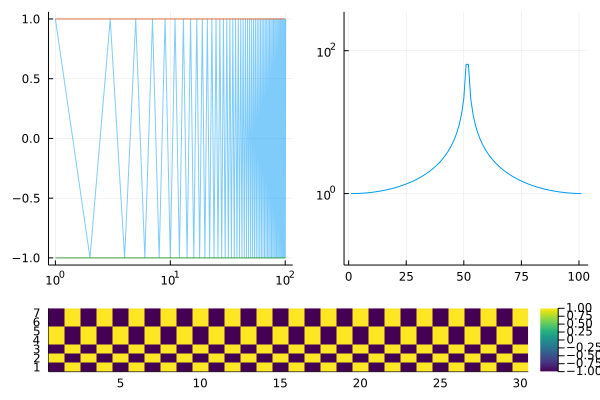

In [63]:
n = 100
realres, spinmap = effAvgAutoCor(100, n, [0,1,0,1,1,0,0], 0.0, 0.0, 0.0, 0.0, 1.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}] 
plot(realres, opacity=0.5,xscale=:log10, legend=false)
plot!(collect(1:2:n),realres[1:2:n])
p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
plot(p1,p21, p3, layout=l)

## MBL with onsite and Ising-even disorder

Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


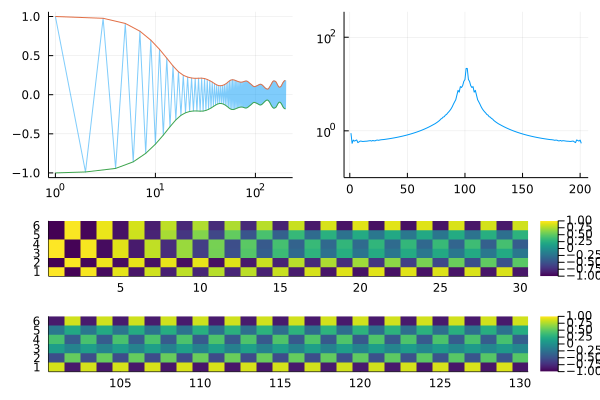

In [65]:
n = 200
init=[1,0,1,1,0,0] #rand([0,1],6)
jz = 0.15
ε = 0.05
σh = pi
realres, spinmap = effAvgAutoCor(100, n, init, ε, jz, 0.2*jz, σh, 0.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}; d{0.2h}] 
plot(realres, opacity=0.5, xscale=:log10, legend=false)
plot!(collect(1:2:n),realres[1:2:n])
p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
howitsgoing = 101:130
p4 = heatmap(collect(howitsgoing), collect(1:length(init)), spinmap[:,howitsgoing], c=:viridis, clims=(-1,1))#print(spinmap[:,1001:1030])
plot(p1,p21, p3, p4, layout=l)

In [68]:
@profile effAvgAutoCor(100, n, init, ε, jz, 0.2*jz, σh, 0.0)


Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


([1.0; -0.9876883405951403; … ; -0.09234544743953414; 0.09263431950479456], [1.0 -0.9876883405951402 … -0.8525665865511455 0.853159190648102; -1.0 0.9876883405951402 … 0.4847797165442712 -0.4851861289879543; … ; -1.0 0.9876883405951395 … 0.25392446215646186 -0.2506612845001131; -1.0 0.9876883405951404 … 0.8461004638796211 -0.8474000622391883])

In [21]:
using BenchmarkTools


In [67]:
function tester()
    l = 8
    h = zeros(2^l,2^l)
    js = randn(l-1)
    jt = rand([0.0,0.0,0.0,0.0,1.0],2^l,2^l,l-1)
    @btime adder(l,h,js,jt)
end

function stester()
    #Profile.clear()
    l = 8
    h = zeros(2^l,2^l)
    js = randn(l-1)
    jt = rand([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0],2^l,2^l,l-1)
    smats = Array{Union{Nothing,SparseMatrixCSC}}(nothing,l-1)
    #show(stdout, "text/plain",smats)
    for i in 1:l-1
        smats[i] = sparse(jt[:,:,i])
    end
    #show(stdout, "text/plain",smats)
    #return smats
    #for i in 1:100
    @time sadder(l,h,js,smats)
    #end
end

function adder(l, h, js, jt)
    for i in 1:2^l, j in 1:2^l
        h[i,j] = 0.0
    end
    for k in 1:length(js)
        h[:,:] .+= js[k] .* view(jt,:,:,k)
    end
end
function sadder(l, h, js, smats)
    for i in 1:2^l, j in 1:2^l
        h[i,j] = 0.0
    end
    for k in eachindex(smats[1])
        #h .+= js[k] .* smats[k]
        println(k)
    end
end
stester()

CartesianIndex(1, 1)
CartesianIndex(2, 1)
CartesianIndex(3, 1)
CartesianIndex(4, 1)
CartesianIndex(5, 1)
CartesianIndex(6, 1)
CartesianIndex(7, 1)
CartesianIndex(8, 1)
CartesianIndex(9, 1)
CartesianIndex(10, 1)
CartesianIndex(11, 1)
CartesianIndex(12, 1)
CartesianIndex(13, 1)
CartesianIndex(14, 1)
CartesianIndex(15, 1)
CartesianIndex(16, 1)
CartesianIndex(17, 1)
CartesianIndex(18, 1)
CartesianIndex(19, 1)
CartesianIndex(20, 1)
CartesianIndex(21, 1)
CartesianIndex(22, 1)
CartesianIndex(23, 1)
CartesianIndex(24, 1)
CartesianIndex(25, 1)
CartesianIndex(26, 1)
CartesianIndex(27, 1)
CartesianIndex(28, 1)
CartesianIndex(29, 1)
CartesianIndex(30, 1)
CartesianIndex(31, 1)
CartesianIndex(32, 1)
CartesianIndex(33, 1)
CartesianIndex(34, 1)
CartesianIndex(35, 1)
CartesianIndex(36, 1)
CartesianIndex(37, 1)
CartesianIndex(38, 1)
CartesianIndex(39, 1)
CartesianIndex(40, 1)
CartesianIndex(41, 1)
CartesianIndex(42, 1)
CartesianIndex(43, 1)
CartesianIndex(44, 1)
CartesianIndex(45, 1)
CartesianIndex(46, 

Excessive output truncated after 524289 bytes.

 86)
CartesianIndex(153, 86)
CartesianIndex(154, 86)
CartesianIndex(155, 86)
CartesianIndex(156, 86)
CartesianIndex(157, 86)
CartesianIndex(158, 86)
CartesianIndex(159, 86)
CartesianIndex(160, 86)
CartesianIndex(161, 86)
CartesianIndex(162, 86)
CartesianIndex(163, 86)
CartesianIndex(164, 86)
CartesianIndex(165, 86)
CartesianIndex(166, 86)
CartesianIndex(167, 86)
CartesianIndex(168, 86)
CartesianIndex(169, 86)
CartesianIndex(170, 86)
CartesianIndex(171, 86)
CartesianIndex(172, 86)
CartesianIndex(173, 86)
CartesianIndex(174, 86)
CartesianIndex(175, 86)
CartesianIndex(176, 86)
CartesianIndex(177, 86)
CartesianIndex(178, 86)
CartesianIndex(179, 86)
CartesianIndex(180, 86)
CartesianIndex(181, 86)
CartesianIndex(182, 86)
CartesianIndex(183, 86)
CartesianIndex(184, 86)
CartesianIndex(185, 86)
CartesianIndex(186, 86)
CartesianIndex(187, 86)
CartesianIndex(188, 86)
CartesianIndex(189, 86)
CartesianIndex(190, 86)
CartesianIndex(191, 86)
CartesianIndex(192, 86)
CartesianIndex(193, 86)
CartesianIn

In [73]:
sparse(randn(3,3,3))

LoadError: MethodError: no method matching sparse(::Array{Float64, 3})
[0mClosest candidates are:
[0m  sparse(::Any, [91m::Any[39m, [91m::Number[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/SparseArrays/src/sparsematrix.jl:950
[0m  sparse(::Any, [91m::Any[39m, [91m::Number[39m, [91m::Any[39m, [91m::Any[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/SparseArrays/src/sparsematrix.jl:954
[0m  sparse(::Any, [91m::Any[39m, [91m::AbstractVector{Bool}[39m, [91m::Any[39m, [91m::Any[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/SparseArrays/src/sparsematrix.jl:958
[0m  ...